<a href="https://colab.research.google.com/github/JEEVA-JOSLIN/Identification-of-different-medicinal-leaves-and-raw-materials/blob/main/siamese_for_leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, utils, callbacks

In [ ]:
def make_pairs(images, labels, seed=19):
    np.random.seed(seed)
    pairImages = []
    pairLabels = []

    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(numClasses)]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]

        idxB = np.random.choice(idx[label])
        posImage = images[idxB]

        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]

        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    return (np.array(pairImages), np.array(pairLabels))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
main_data_dir = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'
batch_size = 32
num_classes = len(os.listdir(main_data_dir))
epochs = 10

In [ ]:
%%time
trainX, trainY, testX, testY =split( os.listdir(main_data_dir))
print (trainX)
trainX = 1 - (trainX / 255.0)
testX  = 1 - (testX / 255.0)

trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

print(f'\nTrain Data Shape: {pairTrain.shape}')
print(f'Test  Data Shape: {pairTest.shape}\n\n')

NameError: ignored

In [ ]:
import os
import random
import shutil

# Paths
dataset_dir = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'
train_dir = '/content/gdrive/MyDrive/train1'
test_dir = '/content/gdrive/MyDrive/test1'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split ratio (adjust as needed)
split_ratio = 0.8

# Iterate through each class folder in the dataset directory
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)

    # Create subfolders for train and test in the train and test directories
    train_class_folder = os.path.join(train_dir, class_folder)
    test_class_folder = os.path.join(test_dir, class_folder)

    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)

    # List all image files in the current class folder
    images = os.listdir(class_path)

    # Shuffle the images
    random.shuffle(images)

    # Calculate the number of images to move to the test set
    num_test_images = int(len(images) * (1 - split_ratio))

    # Move the selected test images to the test class folder
    for i in range(num_test_images):
        image = images[i]
        src = os.path.join(class_path, image)
        dest = os.path.join(test_class_folder, image)
        shutil.move(src, dest)

    # Move the remaining images (training images) to the train class folder
    for i in range(num_test_images, len(images)):
        image = images[i]
        src = os.path.join(class_path, image)
        dest = os.path.join(train_class_folder, image)
        shutil.move(src, dest)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Input
def create_siamese_network(input_shape):
    input = Input(input_shape)
    x = Conv2D(64, (2, 2), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    return Model(input, x)

input_shape = (1601,1201,3)
siamese_network = create_siamese_network(input_shape)

# Define the Siamese network for both anchor and positive images
input_anchor = Input(input_shape)
input_positive = Input(input_shape)

output_anchor = siamese_network(input_anchor)
output_positive = siamese_network(input_positive)

# Define the contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0)))

# Create the Siamese model
siamese_model = Model(inputs=[input_anchor, input_positive], outputs=output_anchor)
siamese_model.compile(loss=contrastive_loss, optimizer=Adam(lr=0.001))

# Define a function to generate Siamese pairs
def generate_siamese_pairs(images, labels, num_pairs):
    anchor_images, positive_images, labels = [], [], []
    for _ in range(num_pairs):
        # Randomly select a class
        class_idx = np.random.choice(np.unique(labels))
        # Select two images from the same class
        class_indices = np.where(labels == class_idx)[0]
        anchor_idx, positive_idx = np.random.choice(class_indices, size=2, replace=False)
        anchor_images.append(images[anchor_idx])
        positive_images.append(images[positive_idx])
        labels.append(1)

        # Select two images from different classes
        class_indices = np.where(labels != class_idx)[0]
        negative_idx = np.random.choice(class_indices)
        anchor_images.append(images[anchor_idx])
        positive_images.append(images[negative_idx])
        labels.append(0)

    return [np.array(anchor_images), np.array(positive_images)], np.array(labels)

# Example usage: Generate pairs for training
num_pairs = 100  # Adjust as needed
train_pairs, train_labels = generate_siamese_pairs(train_images, train_labels, num_pairs)

# Train the Siamese model
siamese_model.fit(train_pairs, train_labels, epochs=5, batch_size=3, validation_data=(test_pairs, test_labels))


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load and preprocess your dataset
# Assuming your dataset contains images in subfolders by class
# Replace this with your actual dataset processing code

dataset_path = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'

# Create a list of all image file paths
image_paths = []
labels = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for image_filename in os.listdir(class_path):
            if image_filename.endswith('.jpg'):
                image_path = os.path.join(class_path, image_filename)
                image_paths.append(image_path)
                labels.append(class_folder)  # You may need to encode class labels
print(image_paths)
# Shuffle the dataset
image_paths, labels = shuffle(image_paths, labels, random_state=42)

# Split your dataset into training and testing sets# Split your dataset into training and testing sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, random_state=42)


# Define a function to load and preprocess images
def load_and_preprocess_image(image_path):
    # Load the image using your preferred method (e.g., PIL, OpenCV)
    # Preprocess the image (resize, normalize pixel values, etc.)
    # Return the preprocessed image data
    pass  # Implement this according to your dataset

# Load and preprocess training and testing images
X_train = np.array([load_and_preprocess_image(path) for path in X_train_paths])
X_test = np.array([load_and_preprocess_image(path) for path in X_test_paths])

# Define the CNN architecture
input_shape = X_train[0].shape
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Replace 'num_classes' with the number of classes in your dataset
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

# Train the model
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test, y_test_one_hot))

# Evaluate the model and make predictions as needed


[]


ValueError: ignored

In [ ]:
import os
import random

# Define the path to your dataset
dataset_path = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'

# Create lists to store positive and negative pairs
positive_pairs = []
negative_pairs = []

# List all class folders in the dataset directory
class_folders = os.listdir(dataset_path)

# Iterate through each class
for class_folder in class_folders:
    class_path = os.path.join(dataset_path, class_folder)
    images = os.listdir(class_path)

    # Create positive pairs (similar images) within the same class
    for i in range(len(images)):
        for j in range(i+1, len(images)):
            img1 = os.path.join(class_path, images[i])
            img2 = os.path.join(class_path, images[j])
            positive_pairs.append((img1, img2, 1))

    # Create negative pairs (dissimilar images) by pairing with images from other classes
    for other_class_folder in class_folders:
        if other_class_folder != class_folder:
            other_class_path = os.path.join(dataset_path, other_class_folder)
            other_images = os.listdir(other_class_path)

            for img1 in images:
                img2 = os.path.join(other_class_path, random.choice(other_images))
                negative_pairs.append((os.path.join(class_path, img1), img2, 0))

# Combine positive and negative pairs
all_pairs = positive_pairs + negative_pairs

# Shuffle the pairs
random.shuffle(all_pairs)

# Split the dataset into training and testing sets
split_ratio = 0.8  # Adjust as needed
split_index = int(len(all_pairs) * split_ratio)
train_pairs = all_pairs[:split_index]
test_pairs = all_pairs[split_index:]

# Now you have train_pairs and test_pairs with paired images and labels

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.backend as K

def triplet_loss(y_true, y_pred, alpha=0.2):
    """
    Compute the triplet loss.

    Arguments:
    y_true -- true labels, required when you define a loss in Keras, but we don't need it for this loss
    y_pred -- the embeddings from the Siamese network

    Returns:
    loss -- real number, value of the loss
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # Compute the pairwise Euclidean distances
    pos_dist = K.sum(K.square(anchor - positive), axis=-1)
    neg_dist = K.sum(K.square(anchor - negative), axis=-1)

    # Compute the triplet loss
    loss = K.maximum(pos_dist - neg_dist + alpha, 0.0)

    return loss

# Now you can use the triplet_loss function in your Siamese network


# Define the Siamese network architecture
def create_siamese_network(input_shape):
    input = Input(input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    return Model(input, x)

# Define the Siamese model with triplet loss
def create_siamese_triplet_model(input_shape):
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')

    siamese_network = create_siamese_network(input_shape)

    anchor_embedding = siamese_network(anchor_input)
    positive_embedding = siamese_network(positive_input)
    negative_embedding = siamese_network(negative_input)

    merged_vector = Lambda(lambda x: tf.concat(x, axis=-1))([anchor_embedding, positive_embedding, negative_embedding])

    return Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_vector)

# Load and preprocess your dataset
# Replace this with your dataset loading and preprocessing code

# Split your dataset into training and testing sets
# Replace this with your dataset splitting code

# Create anchor-positive-negative triplets
def create_triplets(X, y):
    triplets = []
    num_classes = len(np.unique(y))

    for i in range(len(X)):
        anchor = X[i]
        anchor_class = y[i]

        positive_indices = np.where(y == anchor_class)[0]
        negative_indices = np.where(y != anchor_class)[0]

        positive = X[random.choice(positive_indices)]
        negative = X[random.choice(negative_indices)]

        triplets.append((anchor, positive, negative))

    return np.array(triplets)

triplets_train = create_triplets(X_train, y_train)
triplets_test = create_triplets(X_test, y_test)

# Create and compile the Siamese triplet model
input_shape = (your_image_height, your_image_width, your_num_channels)
siamese_triplet_model = create_siamese_triplet_model(input_shape)

siamese_triplet_model.compile(loss=triplet_loss, optimizer=Adam(learning_rate=0.001))

# Train the Siamese triplet model
siamese_triplet_model.fit([triplets_train[:, 0], triplets_train[:, 1], triplets_train[:, 2]], np.zeros(len(triplets_train)), epochs=10, batch_size=32, validation_data=([triplets_test[:, 0], triplets_test[:, 1], triplets_test[:, 2]], np.zeros(len(triplets_test))))

# Embed your images using the trained Siamese network for leaf identification
# You can use the embeddings for similarity comparisons


NameError: ignored

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import triplet_loss
from sklearn.model_selection import train_test_split

# Load and preprocess your dataset
def load_and_preprocess_image(image_path):
    # Load the image using your preferred method (e.g., PIL, OpenCV)
    # Preprocess the image (resize, normalize pixel values, etc.)
    # Return the preprocessed image data
    pass  # Implement this according to your dataset

# Load your dataset and labels
dataset_path = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'
image_paths = []
labels = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for image_filename in os.listdir(class_path):
            if image_filename.endswith('.jpg'):
                image_path = os.path.join(class_path, image_filename)
                image_paths.append(image_path)
                labels.append(class_folder)  # You may need to encode class labels

# Shuffle the dataset
image_paths, labels = shuffle(image_paths, labels, random_state=42)

# Split your dataset into training and testing sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Load and preprocess training and testing images
X_train = np.array([load_and_preprocess_image(path) for path in X_train_paths])
X_test = np.array([load_and_preprocess_image(path) for path in X_test_paths])

# Create anchor-positive-negative triplets as described in previous code examples

# Now you can use X_train and X_test for training and testing the Siamese network



ImportError: ignored

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

# Load and preprocess your dataset
def load_and_preprocess_image(image_path):
    # Load the image using your preferred method (e.g., PIL, OpenCV)
    # Preprocess the image (resize, normalize pixel values, etc.)
    # Return the preprocessed image data
    pass  # Implement this according to your dataset

# Load your dataset and labels
dataset_path = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'
image_paths = []
labels = []
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    for image_filename in os.listdir(class_path):
      image_path = os.path.join(class_path, image_filename)
      print(image_path)
      image_paths.append(image_path)
      labels.append(class_folder) # You may need to encode class labels

# Shuffle the dataset
image_paths, labels = shuffle(image_paths, labels, random_state=42)

# Split your dataset into training and testing sets
#X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


# Create pairs of images for training (positive and negative pairs)
def create_pairs(X, y):
    pairs = []
    labels = []
    num_classes = len(np.unique(y))

    for i in range(len(X)):
        anchor = X[i]
        anchor_class = y[i]

        # Create positive pairs (images of the same class)
        positive_indices = np.where(y == anchor_class)[0]
        positive = X[random.choice(positive_indices)]

        # Create negative pairs (images of different classes)
        negative_indices = np.where(y != anchor_class)[0]
        negative = X[random.choice(negative_indices)]

        pairs.append([anchor, positive])
        labels.append(1)  # Positive pair

        pairs.append([anchor, negative])
        labels.append(0)  # Negative pair

    return np.array(pairs), np.array(labels)




In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

# Load and preprocess your dataset
def load_and_preprocess_image(image_path):
    # Load the image using your preferred method (e.g., PIL, OpenCV)
    # Preprocess the image (resize, normalize pixel values, etc.)
    # Return the preprocessed image data
    pass  # Implement this according to your dataset

# Load your dataset and labels
dataset_path = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'
image_paths = []
labels = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for image_filename in os.listdir(class_path):
            if image_filename.endswith('.jpg'):
                image_path = os.path.join(class_path, image_filename)
                image_paths.append(image_path)
                labels.append(class_folder) # You may need to encode class labels

# Shuffle the dataset
image_paths, labels = shuffle(image_paths, labels, random_state=42)

# Split your dataset into training and testing sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Load and preprocess training and testing images
X_train = np.array([load_and_preprocess_image(path) for path in X_train_paths])
X_test = np.array([load_and_preprocess_image(path) for path in X_test_paths])

# Define the Siamese network architecture
def create_siamese_network(input_shape):
    input = Input(input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    return Model(input, x)

# Define the Siamese model
def create_siamese_model(input_shape):
    input_anchor = Input(input_shape)
    input_positive = Input(input_shape)
    input_negative = Input(input_shape)

    siamese_network = create_siamese_network(input_shape)

    output_anchor = siamese_network(input_anchor)
    output_positive = siamese_network(input_positive)
    output_negative = siamese_network(input_negative)

    return Model(inputs=[input_anchor, input_positive, input_negative], outputs=[output_anchor, output_positive, output_negative])

# Create positive and negative pairs for training
def create_positive_and_negative_pairs(X, y):
    positive_pairs = []
    negative_pairs = []

    for i in range(len(X)):
        anchor_image = X[i]
        anchor_label = y[i]

        # Randomly select a positive example (image of the same class)
        positive_indices = np.where(y == anchor_label)[0]
        positive_image = X[random.choice(positive_indices)]

        # Randomly select a negative example (image of a different class)
        negative_indices = np.where(y != anchor_label)[0]
        negative_image = X[random.choice(negative_indices)]

        positive_pairs.append((anchor_image, positive_image))
        negative_pairs.append((anchor_image, negative_image))

    return positive_pairs, negative_pairs

# Create positive and negative pairs for training
positive_pairs_train, negative_pairs_train = create_positive_and_negative_pairs(X_train, y_train)

# Define the Siamese model
input_shape = X_train[0].shape
siamese_model = create_siamese_model(input_shape)

# Compile the Siamese model with binary cross-entropy loss
siamese_model.compile(optimizer=Adam(learning_rate=0.001), loss=[binary_crossentropy, binary_crossentropy, binary_crossentropy])

# Prepare training data
anchor_train = np.array([pair[0] for pair in positive_pairs_train + negative_pairs_train])
positive_train = np.array([pair[0] for pair in positive_pairs_train])
negative_train = np.array([pair[0] for pair in negative_pairs_train])

# Create labels (1 for positive pairs, 0 for negative pairs)
labels_train = [1] * len(positive_pairs_train) + [0] * len(negative_pairs_train)

# Train the Siamese model
siamese_model.fit([anchor_train, positive_train, negative_train], [labels_train, labels_train, labels_train], epochs=10, batch_size=32)

# Evaluate the Siamese model on your testing data
# You can use the trained Siamese network to make similarity comparisons


IndexError: ignored

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image

# Define the image size (modify according to your dataset)
image_size = (224, 224)

# Load your dataset and labels
dataset_path = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'
image_paths = []
labels = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for image_filename in os.listdir(class_path):
            if image_filename.endswith('.jpg'):
                image_path = os.path.join(class_path, image_filename)
                image_paths.append(image_path)
                labels.append(class_folder)  # You may need to encode class labels

# Shuffle the dataset
image_paths, labels = shuffle(image_paths, labels, random_state=42)

# Split your dataset into training and testing sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Define the Siamese network architecture
def create_siamese_network(input_shape):
    input = Input(input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    return Model(input, x)

# Define the Siamese model
def create_siamese_model(input_shape):
    input_anchor = Input(input_shape)
    input_positive = Input(input_shape)
    input_negative = Input(input_shape)

    siamese_network = create_siamese_network(input_shape)

    output_anchor = siamese_network(input_anchor)
    output_positive = siamese_network(input_positive)
    output_negative = siamese_network(input_negative)

    return Model(inputs=[input_anchor, input_positive, input_negative], outputs=[output_anchor, output_positive, output_negative])

# Create positive and negative pairs for training
def create_positive_and_negative_pairs(X_paths, y):
    positive_pairs = []
    negative_pairs = []

    for i in range(len(X_paths)):
        anchor_image_path = X_paths[i]
        anchor_label = y[i]

        # Randomly select a positive example (image of the same class)
        positive_indices = [j for j, label in enumerate(y) if label == anchor_label]
        positive_image_path = X_paths[random.choice(positive_indices)]

        # Randomly select a negative example (image of a different class)
        negative_indices = [j for j, label in enumerate(y) if label != anchor_label]
        negative_image_path = X_paths[random.choice(negative_indices)]

        positive_pairs.append((anchor_image_path, positive_image_path))
        negative_pairs.append((anchor_image_path, negative_image_path))

    return positive_pairs, negative_pairs

# Create positive and negative pairs for training
positive_pairs_train, negative_pairs_train = create_positive_and_negative_pairs(X_train_paths, y_train)

# Define the Siamese model
input_shape = image_size + (3,)  # Assuming RGB images
input_shape=(224,224,3)
siamese_model = create_siamese_model(input_shape)

# Compile the Siamese model with triplet loss
siamese_model.compile(optimizer=Adam(learning_rate=0.001), loss=['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy'])

# Prepare training data
anchor_train = np.array([np.array(Image.open(pair[0]).resize(image_size)) for pair in positive_pairs_train + negative_pairs_train])
positive_train = np.array([np.array(Image.open(pair[1]).resize(image_size)) for pair in positive_pairs_train])
negative_train = np.array([np.array(Image.open(pair[1]).resize(image_size)) for pair in negative_pairs_train])

# Create labels (1 for positive pairs, 0 for negative pairs)
labels_train = [1] * len(positive_pairs_train) + [0] * len(negative_pairs_train)
# Prepare training data
print("Anchor shape:", anchor_train.shape)
print("Positive shape:", positive_train.shape)
print("Negative shape:", negative_train.shape)
print("Anchor dtype:", anchor_train.dtype)
print("Positive dtype:", positive_train.dtype)
print("Negative dtype:", negative_train.dtype)


# Evaluate the Siamese model on your testing data
# You can use the trained Siamese network to make similarity comparisons


Anchor shape: (248, 224, 224, 3)
Positive shape: (124, 224, 224, 3)
Negative shape: (124, 224, 224, 3)
Anchor dtype: uint8
Positive dtype: uint8
Negative dtype: uint8


In [ ]:
siamese_model.fit(
    [anchor_train, positive_train, negative_train],
    [labels_train, labels_train, labels_train],
    epochs=10,
    batch_size=32
)

ValueError: ignored

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image

# Define the image size (modify according to your dataset)
image_size = (224, 224)

# Load your dataset and labels
dataset_path = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'
image_paths = []
labels = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for image_filename in os.listdir(class_path):
            if image_filename.endswith('.jpg'):
                image_path = os.path.join(class_path, image_filename)
                image_paths.append(image_path)
                if class_folder=='Alpinia Galanga (Rasna)':
                  labels.append("0")  # You may need to encode class labels
                else:
                  labels.append("1")


# Shuffle the dataset
image_paths, labels = shuffle(image_paths, labels, random_state=42)

# Split your dataset into training and testing sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Define the Siamese network architecture
def create_siamese_network(input_shape):
    input = Input(input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    return Model(input, x)

# Define the Siamese model
def create_siamese_model(input_shape):
    input_anchor = Input(input_shape)
    input_positive = Input(input_shape)
    input_negative = Input(input_shape)

    siamese_network = create_siamese_network(input_shape)

    output_anchor = siamese_network(input_anchor)
    output_positive = siamese_network(input_positive)
    output_negative = siamese_network(input_negative)

    return Model(inputs=[input_anchor, input_positive, input_negative], outputs=[output_anchor, output_positive, output_negative])

# Create positive and negative pairs for training
def create_positive_and_negative_pairs(X_paths, y):
    positive_pairs = []
    negative_pairs = []

    for i in range(len(X_paths)):
        anchor_image_path = X_paths[i]
        anchor_label = y[i]

        # Randomly select a positive example (image of the same class)
        positive_indices = [j for j, label in enumerate(y) if label == anchor_label]
        positive_image_path = X_paths[random.choice(positive_indices)]

        # Randomly select a negative example (image of a different class)
        negative_indices = [j for j, label in enumerate(y) if label != anchor_label]
        negative_image_path = X_paths[random.choice(negative_indices)]

        positive_pairs.append((anchor_image_path, positive_image_path))
        negative_pairs.append((anchor_image_path, negative_image_path))

    return positive_pairs, negative_pairs

# Create positive and negative pairs for training
positive_pairs_train, negative_pairs_train = create_positive_and_negative_pairs(X_train_paths, y_train)

# Define the Siamese model
input_shape = image_size + (3,)  # Assuming RGB images
siamese_model = create_siamese_model(input_shape)

# Compile the Siamese model with triplet loss
siamese_model.compile(optimizer=Adam(learning_rate=0.001), loss=['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy'])

# Prepare training data
anchor_train = np.array([np.array(Image.open(pair[0]).resize(image_size)) for pair in positive_pairs_train + negative_pairs_train])
positive_train = np.array([np.array(Image.open(pair[1]).resize(image_size)) for pair in positive_pairs_train])
negative_train = np.array([np.array(Image.open(pair[1]).resize(image_size)) for pair in negative_pairs_train])

# Create labels (1 for positive pairs, 0 for negative pairs)
labels_train = [1] * len(positive_pairs_train) + [0] * len(negative_pairs_train)

# Train the Siamese model
siamese_model.fit([anchor_train, positive_train, negative_train], [labels_train, labels_train, labels_train], epochs=10, batch_size=32)

# Evaluate the Siamese model on your testing data
# You can use the trained Siamese network to make similarity comparisons


ValueError: ignored

In [ ]:
import tensorflow as tf

# Load the dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/train1', labels='inferred', label_mode='int', color_mode='rgb', batch_size=32)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/Segmented Medicinal Leaf Images', labels='inferred', label_mode='int', color_mode='rgb', batch_size=32)

# Split the dataset into training and validation sets
import tensorflow as tf

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/Segmented Medicinal Leaf Images', labels='inferred', label_mode='int', color_mode='rgb', batch_size=32)

# Split the dataset into training and validation sets
train_dataset, validation_dataset = dataset.split(0.25, shuffle=True)


# Preprocess the images
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, (128, 128)), y))
validation_dataset = validation_dataset.map(lambda x, y: (tf.image.resize(x, (128, 128)), y))

# Create the Siamese network
siamese_network = SiameseNetwork()

# Compile the Siamese network
siamese_network.compile(optimizer='adam', loss='contrastive_loss')

# Train the Siamese network
siamese_network.fit(train_dataset, epochs=10)

# Evaluate the Siamese network on the validation set
validation_loss, validation_accuracy = siamese_network.evaluate(validation_dataset)

print('Validation loss:', validation_loss)
print('Validation accuracy:', validation_accuracy)

Found 184 files belonging to 3 classes.
Found 156 files belonging to 3 classes.
Found 156 files belonging to 3 classes.


AttributeError: ignored

In [ ]:
import tensorflow as tf

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/Segmented Medicinal Leaf Images', labels='inferred', label_mode='int', color_mode='rgb', batch_size=32)

# Split the dataset into training and validation sets
train_dataset, validation_dataset = dataset.split(0.25, shuffle=True)

# Batch the training and validation sets
train_dataset = train_dataset.batch(32)
validation_dataset = validation_dataset.batch(32)


Found 156 files belonging to 3 classes.


AttributeError: ignored

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Step 1: Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/gdrive')

# Step 2: Load and organize your dataset into pairs with labels
def preprocess_image(image):
    # Implement image preprocessing (e.g., resize, normalize) here
    return image

dataset_path = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'
image_pairs = []
labels = []

class_dirs = os.listdir(dataset_path)

for class_dir in class_dirs:
    class_images = os.listdir(os.path.join(dataset_path, class_dir))
    for i in range(len(class_images)):
        for j in range(i + 1, len(class_images)):
            image1 = cv2.imread(os.path.join(dataset_path, class_dir, class_images[i]))
            image2 = cv2.imread(os.path.join(dataset_path, class_dir, class_images[j]))
            image1 = preprocess_image(image1)
            image2 = preprocess_image(image2)
            label = 1 if class_dir == class_dir else 0
            image_pairs.append([image1, image2])
            labels.append(label)

# Convert lists to NumPy arrays
image_pairs = np.array(image_pairs)
labels = np.array(labels)

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_pairs, labels, test_size=0.2, random_state=42)

# Step 4: Define the Siamese network model
def create_siamese_model(input_shape):
    # Define the Siamese network architecture here
    # ...
    return siamese_model

input_shape = X_train[0][0].shape
siamese_model = create_siamese_model(input_shape)

# Step 5: Compile the Siamese network model
siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Step 6: Train the Siamese network
siamese_model.fit([X_train[:, 0], X_train[:, 1]], y_train, validation_data=([X_test[:, 0], X_test[:, 1]], y_test), batch_size=10, epochs=2, verbose=2)

# Step 7: Evaluate the model
loss, accuracy = siamese_model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# Step 8: Use the model for predictions
# You can use the trained Siamese network to make similarity-based predictions on new pairs of images.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import numpy as np
from PIL import Image

def load_leaf_dataset(main_data_dir):
    image_arrays = []
    labels = []
    print("Loading images...")

    for folder_name in os.listdir(main_data_dir):
        print(f"Loading images from {folder_name}...")
        folder_path = os.path.join(main_data_dir, folder_name)
        if os.path.isdir(folder_path):
            label = folder_name.split(" ")[-1][1:-1]  # Extract abbreviation from folder name
            for filename in os.listdir(folder_path):
                print(f"\tLoading {filename}...")
                if filename.endswith(".jpg"):  # Assuming the images are in JPG format
                    image_path = os.path.join(folder_path, filename)
                    try:
                        image = Image.open(image_path)
                        image_array = np.array(image)
                        image_arrays.append(image_array)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error loading {image_path}: {str(e)}")

    # Convert lists to numpy arrays
    image_arrays = np.array(image_arrays)
    labels = np.array(labels)

    return image_arrays, labels


# Example usage:
main_data_dir = "./Medicinal Leaf Dataset/Segmented Medicinal Leaf Images"
image_arrays, labels = load_leaf_dataset(main_data_dir)

Loading images...


FileNotFoundError: ignored

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from google.colab import drive

# Step 1: Mount Google Drive to access your dataset
drive.mount('/content/gdrive')

# Step 2: Load and organize your dataset into pairs with labels
def preprocess_image(image):
    # Implement image preprocessing (e.g., resize, normalize) here
    return image

dataset_path = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'
image_pairs = []
labels = []

class_dirs = os.listdir(dataset_path)

for class_dir in class_dirs:
    class_images = os.listdir(os.path.join(dataset_path, class_dir))
    for i in range(len(class_images)):
        for j in range(i + 1, len(class_images)):
            image1 = cv2.imread(os.path.join(dataset_path, class_dir, class_images[i]))
            image2 = cv2.imread(os.path.join(dataset_path, class_dir, class_images[j]))
            image1 = preprocess_image(image1)
            image2 = preprocess_image(image2)
            label = 1 if class_dir == class_dir else 0
            image_pairs.append([image1, image2])
            labels.append(label)

# Convert lists to NumPy arrays
image_pairs = np.array(image_pairs)
labels = np.array(labels)

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_pairs, labels, test_size=0.2, random_state=42)

# Step 4: Define the Siamese network model
def create_siamese_model(input_shape):
    # Define the Siamese network architecture here
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    base_model = tf.keras.Sequential([
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(256, activation='relu')
    ])

    features_1 = base_model(input_1)
    features_2 = base_model(input_2)

    # Calculate L1 distance between the feature vectors
    L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([features_1, features_2])

    output = Dense(1, activation='sigmoid')(L1_distance)

    siamese_model = Model(inputs=[input_1, input_2], outputs=output)

    return siamese_model

input_shape = X_train[0][0].shape
siamese_model = create_siamese_model(input_shape)

# Step 5: Compile the Siamese network model
siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Step 6: Train the Siamese network
siamese_model.fit([X_train[:, 0], X_train[:, 1]], y_train, validation_data=([X_test[:, 0], X_test[:, 1]], y_test), batch_size=32, epochs=20, verbose=2)

# Step 7: Evaluate the model
loss, accuracy = siamese_model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# Step 8: Use the model for predictions
# You can use the trained Siamese network to make similarity-based predictions on new pairs of images.


KeyboardInterrupt: ignored

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from google.colab import drive

# Step 1: Mount Google Drive to access your dataset
drive.mount('/content/gdrive')

# Step 2: Load and organize your dataset into pairs with labels
def preprocess_image(image):
    # Implement image preprocessing (e.g., resize, normalize) here
    return image

dataset_path = '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'
image_pairs = []
labels = []

class_dirs = os.listdir(dataset_path)

for class_dir in class_dirs:
    class_images = os.listdir(os.path.join(dataset_path, class_dir))
    for i in range(len(class_images)):
        for j in range(i + 1, len(class_images)):
            image1 = cv2.imread(os.path.join(dataset_path, class_dir, class_images[i]))
            image2 = cv2.imread(os.path.join(dataset_path, class_dir, class_images[j]))
            image1 = preprocess_image(image1)
            image2 = preprocess_image(image2)
            label = 1 if class_dir == class_dir else 0
            image_pairs.append([image1, image2])
            labels.append(label)

# Convert lists to NumPy arrays
image_pairs = np.array(image_pairs)
labels = np.array(labels)

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_pairs, labels, test_size=0.2, random_state=42)

# Step 4: Define the Siamese network model
def create_siamese_model(input_shape):
    # Define the Siamese network architecture here
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    base_model = tf.keras.Sequential([
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(256, activation='relu')
    ])

    features_1 = base_model(input_1)
    features_2 = base_model(input_2)

    # Calculate L1 distance between the feature vectors
    L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([features_1, features_2])

    output = Dense(1, activation='sigmoid')(L1_distance)

    siamese_model = Model(inputs=[input_1, input_2], outputs=output)

    return siamese_model

input_shape = X_train[0][0].shape
siamese_model = create_siamese_model(input_shape)

# Step 5: Compile the Siamese network model
siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Step 6: Train the Siamese network
siamese_model.fit([X_train[:, 0], X_train[:, 1]], y_train, validation_data=([X_test[:, 0], X_test[:, 1]], y_test), batch_size=10, epochs=20, verbose=2)

# Step 7: Evaluate the model
loss, accuracy = siamese_model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# Step 8: Use the model for predictions
# You can use the trained Siamese network to make similarity-based predictions on new pairs of images.


Mounted at /content/gdrive


In [ ]:
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, shutil
from random import random, randint, seed
import random
import pickle, itertools, sklearn, pandas as pd, seaborn as sn
from scipy.spatial import distance
from keras.models import Model, load_model, Sequential
from keras import backend as K
from keras.utils.vis_utils import plot_model
from scipy import spatial
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')


# Import color encoder which uses siamese networks
from model import train_color_encoder




## Prepare positive and negative pais of data samples


# Prepare data for different shapes but same colors

dir = os.getcwd()+"/shapes/"

images = []
y_col = []

for root, dirs, files in os.walk(dir, topdown=False):
    for name in files:
        fullname = os.path.join(root, name)
        if fullname.find(".png") != -1 :
            images.append(fullname)
            if fullname.find("red") != -1 :
                y_col.append(0)
            elif fullname.find("blue") != -1 :
                y_col.append(1)
            else :
                y_col.append(2)

y_col = np.array(y_col)
images = np.array(images)



# Generate positive samples

red_im = images[np.where(y_col==0)]
green_im = images[np.where(y_col==1)]
blue_im = images[np.where(y_col==2)]

# Test images
test_red_im = red_im[50:]
test_green_im = green_im[50:]
test_blue_im = blue_im[50:]

# Read only 20 images from each class for training
red_im = red_im[:20]
green_im = green_im[:20]
blue_im = blue_im[:20]



positive_red = list(itertools.combinations(red_im, 2))

positive_blue = list(itertools.combinations(blue_im, 2))

positive_green = list(itertools.combinations(green_im, 2))


# Generate negative samples

negative1 = itertools.product(red_im,green_im)
negative1 = list(negative1)

negative2 = itertools.product(green_im,blue_im)
negative2 = list(negative2)

negative3 = itertools.product(red_im,blue_im)
negative3 = list(negative3)


# Create pairs of images and set target label for them. Target output is 1 if pair of images have same color else it is 0.
color_X1 = []
color_X2 = []
color_y = []
positive_samples = positive_blue + positive_green + positive_red
negative_samples = negative1 + negative2 + negative3

for fname in positive_samples :
    im = cv2.imread(fname[0])
    color_X1.append(im)
    im = cv2.imread(fname[1])
    color_X2.append(im)
    color_y.append(1)

for fname in negative_samples :
    im = cv2.imread(fname[0])
    color_X1.append(im)
    im = cv2.imread(fname[1])
    color_X2.append(im)
    color_y.append(0)


color_y = np.array(color_y)
color_X1 = np.array(color_X1)
color_X2 = np.array(color_X2)
color_X1 = color_X1.reshape((len(negative_samples) + len(positive_samples), 28, 28, 3))
color_X2 = color_X2.reshape((len(negative_samples) + len(positive_samples), 28, 28, 3))

color_X1 = 1 - color_X1/255
color_X2 = 1 - color_X2/255

print("Color data : ", color_X1.shape, color_X2.shape, color_y.shape)

# Save test data
f = open(os.getcwd()+"/test_images.pkl", 'wb')
pickle.dump([test_red_im, test_blue_im, test_green_im], f)
f.close()

# train model
train_color_encoder(color_X1, color_X2, color_y)

ModuleNotFoundError: ignored

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda ,Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
base_dir =  '/content/gdrive/MyDrive/Segmented Medicinal Leaf Images'
train_test_split = 0.7
no_of_files_in_each_class = 20

#Read all the folders in the directory
folder_list = os.listdir(base_dir)
print( len(folder_list), "categories found in the dataset")
print(len(folder_list))
#Declare training array
cat_list = []
x = []
y = []
y_label = 0

#Using just 5 images per category
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name))
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((100, 100))))
        y.append(y_label)
    y_label+=1
    cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, cat_list.shape)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
10 categories found in the dataset
10
X, Y shape (200, 100, 100, 3) (200,) (10, 20)


In [ ]:
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

train_files = train_size * no_of_files_in_each_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape of training data :',x_train.shape, 'and', y_train.shape, cat_train.shape)
print('X&Y shape of testing data :' , x_val.shape, 'and', y_val.shape, cat_test.shape)

7 classes for training and 3  classes for testing
X&Y shape of training data : (140, 100, 100, 3) and (140,) (7, 20)
X&Y shape of testing data : (60, 100, 100, 3) and (60,) (3, 20)


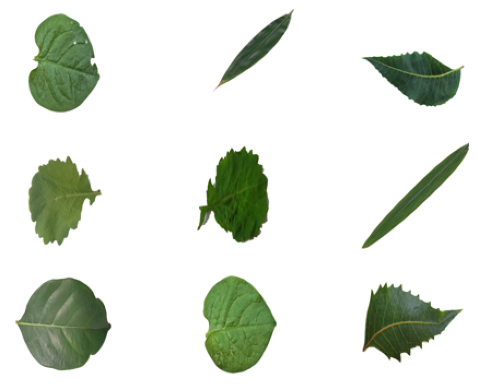

In [ ]:
#Plotting Images
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(x_train[np.random.randint(0, x_train.shape[0]-1)])
plt.show()

In [ ]:
def get_batch(batch_size=64, call_type='train'):

    temp_x = None
    temp_cat_list = None
    start=None
    end=None
    batch_x=[]

    if call_type == 'train':
        temp_x = x_train
        temp_cat_list = cat_train
        start=0
        end = train_size
    else:
        temp_x = x_val
        temp_cat_list = cat_test
        start = train_size+1
        end = len(folder_list)-1

    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)

    class_list = np.random.randint(start, end, batch_size)
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]

    return(batch_x, batch_y)

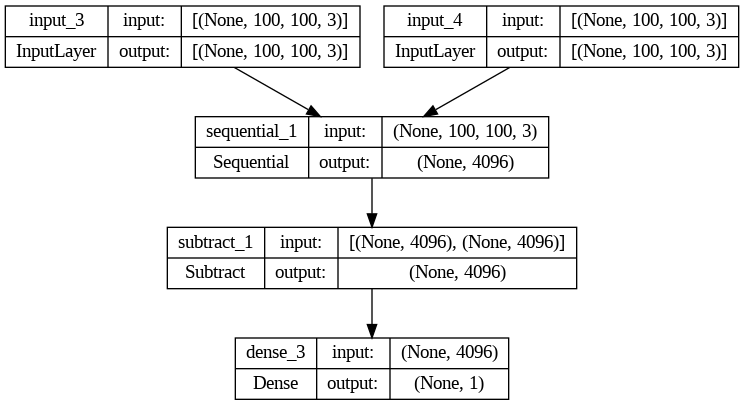

In [ ]:
#Building a sequential model
input_shape=(100, 100, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (7,7), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(256, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='sigmoid', kernel_initializer=W_init, bias_initializer=b_init)
])

encoded_l = model(left_input)
encoded_r = model(right_input)

# L1_distance = lambda x: K.abs(x[0] - x[1])
# print(type(L1_distance))
# both = merge([encoded_l, encoded_r], mode=L1_distance, output_shape = lambda x:x[0])
subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
siamese_net = Model([left_input, right_input],prediction)

optimizer= Adam(learning_rate=0.00006)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

plot_model(siamese_net, show_shapes=True, show_layer_names=True)


In [ ]:
def nway_one_shot(model, n_way, n_val):
    print(cat_list)
    temp_x = x_val
    temp_cat_list = cat_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0

    class_list = np.random.randint(train_size-1, len(folder_list)+1, n_val)
    print(class_list)
    for i in class_list:
      if i<len(cat_list):
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 100, 100, 3)))
        temp.append(np.zeros((n_way, 100, 100, 3)))
        for k in range(0, n_way):
            temp[0][k] = x[j]

            if k==0:
                #print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                #print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        result = siamese_net.predict(temp)
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy


In [ ]:
def get_batch(batch_size=64, call_type='train'):

    temp_x = None
    temp_cat_list = None
    start=None
    end=None
    batch_x=[]

    if call_type == 'train':
        temp_x = x_train
        temp_cat_list = cat_train
        start=0
        end = train_size
    else:
        temp_x = x_val
        temp_cat_list = cat_test
        start = train_size+1
        end = len(folder_list)-1

    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)

    class_list = np.random.randint(start, end, batch_size)
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]

    return(batch_x, batch_y)

In [ ]:
nway_one_shot(model, 5, 7)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19]
 [ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
   38  39]
 [ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
   58  59]
 [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
   78  79]
 [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
   98  99]
 [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
  118 119]
 [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
  138 139]
 [140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
  158 159]
 [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
  178 179]
 [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
  198 199]]
[10 10  6  8 10  6  7]
1/1 [==============================] - 0s 216ms/step
2 correctly classified among 7


28.571428571428573

In [ ]:
epochs =30
n_way = 20
n_val = 100
batch_size = 64
loss_list=[]
accuracy_list=[]
for epoch in range(1,epochs):
    batch_x, batch_y = get_batch(batch_size, call_type="train")
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append((epoch,loss))
    print('Epoch:', epoch, ', Loss:',loss)
    if epoch%5== 0:
        print("=============================================")
        accuracy = nway_one_shot(model, n_way, n_val)
        accuracy_list.append((epoch, accuracy))
        print('Accuracy as of', epoch, 'epochs:', accuracy)
        print("=============================================")
        if(accuracy>99):
            print("Achieved more than 90% Accuracy")
            #break

Epoch: 1 , Loss: 0.7476933002471924
Epoch: 2 , Loss: 0.7475631833076477
Epoch: 3 , Loss: 0.7473987936973572
Epoch: 4 , Loss: 0.7472653985023499
Epoch: 5 , Loss: 0.747016966342926
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19]
 [ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
   38  39]
 [ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
   58  59]
 [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
   78  79]
 [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
   98  99]
 [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
  118 119]
 [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
  138 139]
 [140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
  158 159]
 [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
  178 179]
 [180 181 182 183 184 185 186 187 188 189 190 191 192 19

In [ ]:
model.save('plant_identification_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
label_mapping = {i: label for i, label in enumerate(sorted(os.listdir(base_dir)))}
print(label_mapping)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
image_path='/content/gdrive/MyDrive/image.webp'
# Load the trained model
model = tf.keras.models.load_model('plant_identification_model2.h5')
label_mapping = {i: label for i, label in enumerate(sorted(os.listdir(base_dir)))}

# Load and preprocess the image
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(100,100))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    preprocessed_image = preprocess_input(image_array)
    return preprocessed_image

# Perform prediction
def predict_plant(image_path, label_mapping):
    preprocessed_image = preprocess_image(image_path)

    predictions = model.predict(preprocessed_image)

    # Map model's numeric predictions to labels
    predicted_label_index = np.argmax(predictions)
    predicted_label = label_mapping[0]
    confidence = predictions[0][predicted_label_index]
    return predicted_label, confidence

# Provide the path to the image you want to classify
predicted_label, confidence = predict_plant(image_path, label_mapping)

# Print the prediction
print(f"Predicted Label: {predicted_label}")
print(f"Confidence: {confidence:.2f}")

1/1 [==============================] - 0s 84ms/step
Predicted Label: Alpinia Galanga (Rasna)
Confidence: 0.76
